In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import xarray as xr
import numpy as np
from pathlib import Path

from utils.data import load_config_xval_test_set, load_xval_test_set
from utils.analysis import plot_model_comp
from utils.metrics import compute_metrics
from utils.plotting import load_default_mpl_config, savefig

load_default_mpl_config()

PLOT_PATH = Path('/mydata/machflow/basil/mach-flow/analysis/yearly_vis/')
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']

def common_mask_da(*da):
    mask = True
    for el in da:
        mask *= el.notnull()

    return mask


def get_masked_runoff(ds: xr.Dataset, kw: str = 'Qmm') -> xr.Dataset:
    ds_subset = ds[[var for var in list(ds.data_vars) if var.startswith(kw)]]
    
    mask = ds_subset.to_array().notnull().all('variable').compute()

    ds_subset = ds_subset.where(mask)

    return ds_subset.compute()


def resample_yearly(ds: xr.Dataset, min_frac_present: float = 0.01) -> xr.Dataset:
    ds_yearly = ds.resample(time='1Y').mean()
    ds_yearly_valid = ds.notnull().resample(time='1Y').sum()
    ds_yearly_count = ds.resample(time='1Y').count()

    ds_yearly = ds_yearly.where(ds_yearly_valid / ds_yearly_count > min_frac_present)

    return ds_yearly.compute()

def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.to_dataframe().reset_index()
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

/mydata/machflow/basil/mambaforge/envs/machflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_xval_test_set('../../runs/basin_level/staticall_allbasins/LSTM/xval/')[runoff_vars].sel(tau=0.5).drop_vars('tau').sel(time=slice('2012', None))
ds = get_masked_runoff(ds)
ds_yearly = resample_yearly(ds)

In [3]:
x_mod = compute_metrics(obs=ds_yearly.Qmm, mod=ds_yearly.Qmm_mod, dim='time')
x_prevah = compute_metrics(obs=ds_yearly.Qmm, mod=ds_yearly.Qmm_prevah, dim='time')

/mydata/machflow/basil/mach-flow/utils/metrics.py:190: RuntimeWarning: All-NaN slice encountered
  qsl = np.nansum(mod_s - np.nanmin(mod_s, axis=-1, keepdims=True), axis=-1)
/mydata/machflow/basil/mach-flow/utils/metrics.py:191: RuntimeWarning: All-NaN slice encountered
  qol = np.nansum(obs_s - np.nanmin(obs_s, axis=-1, keepdims=True), axis=-1)
/mydata/machflow/basil/mach-flow/utils/metrics.py:190: RuntimeWarning: All-NaN slice encountered
  qsl = np.nansum(mod_s - np.nanmin(mod_s, axis=-1, keepdims=True), axis=-1)
/mydata/machflow/basil/mach-flow/utils/metrics.py:191: RuntimeWarning: All-NaN slice encountered
  qol = np.nansum(obs_s - np.nanmin(obs_s, axis=-1, keepdims=True), axis=-1)


In [4]:
x_both = merged_df(mod=x_mod, prevah=x_prevah)

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


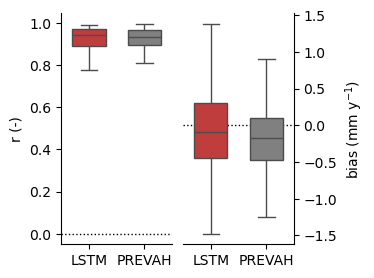

In [15]:
metric_labels = ['r (-)', 'bias (mm y$^{-1}$)']
metrics = ['r', 'bias']

fig, axes = plt.subplots(1, len(metrics), figsize=(3, 3), gridspec_kw={'wspace': 0.1}, squeeze=False)


my_colors = {'mod': 'tab:red', 'prevah': '0.5'}

for i, (metric_label, metric, ax) in enumerate(zip(metric_labels, metrics, axes[0])):
    bplot = sns.boxplot(data=x_both, x='source', y=metric, showfliers=False, hue='source', ax=ax, palette=my_colors, width=0.6)

    if i == 1:
        ax.yaxis.tick_right()
        ax.spines[['left', 'top']].set_visible(False)
        ax.yaxis.set_label_position('right')
    else:
        ax.spines[['right', 'top']].set_visible(False)

    ax.set_ylabel(metric_label)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['LSTM', 'PREVAH'])
    ax.set_xlabel('')
    ax.axhline(color='k', lw=1.0, ls=':', zorder=-1)

savefig(fig, path=PLOT_PATH / 'iav_nse.png')

In [8]:
ds_yearly_tid = ds_yearly.copy()
ds_yearly_tid['time'] = np.arange(len(ds_yearly_tid['time']))
ds_yearly_tid

<xarray.Dataset>
Dimensions:     (time: 12, station: 87)
Coordinates:
  * station     (station) <U9 'CHFO-0089' 'CHFO-0095' ... 'CHFO-0242'
  * time        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    Qmm         (time, station) float32 2.336 2.917 1.978 1.436 ... nan nan nan
    Qmm_mod     (time, station) float32 2.228 2.328 3.096 1.585 ... nan nan nan
    Qmm_prevah  (time, station) float32 2.309 2.365 2.251 1.692 ... nan nan nan

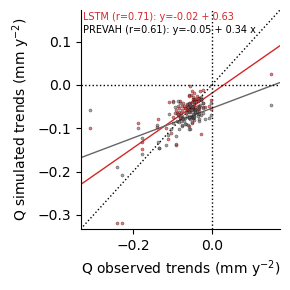

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))

pf = ds_yearly_tid.polyfit(dim='time', deg=1).sel(degree=1)
pf_obs = pf.Qmm_polyfit_coefficients
pf_mod = pf.Qmm_mod_polyfit_coefficients
pf_prevah = pf.Qmm_prevah_polyfit_coefficients

ax.scatter(pf_obs, pf_mod, s=5, label='LSTM', facecolor='tab:red', edgecolor='k', alpha=0.6, lw=0.3)
ax.scatter(pf_obs, pf_prevah, s=5, label='PREVAH', facecolor='0.4', edgecolor='k', alpha=0.6, lw=0.3)

# ax.set_aspect('equal')
xlim = ax.get_xlim()
ylim = ax.get_xlim()
axmin = min(xlim[0], ylim[0])
axmax = max(xlim[1], ylim[1])

mod_coef = np.polyfit(pf_obs, pf_mod, 1)
mod_fn = np.poly1d(mod_coef)
mod_r = np.corrcoef(pf_obs, pf_mod)[0, 1]
prevah_coef = np.polyfit(pf_obs, pf_prevah, 1)
prevah_fn = np.poly1d(prevah_coef)
prevah_r = np.corrcoef(pf_obs, pf_prevah)[0, 1]

ax.plot([axmin, axmax], [mod_fn(axmin), mod_fn(axmax)], lw=1.0, zorder=-1, color='tab:red')
ax.plot([axmin, axmax], [prevah_fn(axmin), prevah_fn(axmax)], lw=1.0, zorder=-1, color='0.4')

ax.text(0.01, 0.99, f'LSTM (r={mod_r:0.2f}): y={mod_coef[1]:0.2f} + {mod_coef[0]:0.2f}',
        ha='left', va='top', transform=ax.transAxes, color='tab:red', size=7)
ax.text(0.01, 0.93, f'PREVAH (r={prevah_r:0.2f}): y={prevah_coef[1]:0.2f} + {prevah_coef[0]:0.2f} x',
        ha='left', va='top', transform=ax.transAxes, color='k', size=7)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k', lw=1.0, ls=':', zorder=-1)
ax.axvline(0, color='k', lw=1.0, ls=':', zorder=-1)
ax.axhline(0, color='k', lw=1.0, ls=':', zorder=-1)
ax.set_xlabel('Q observed trends (mm y$^{-2}$)')
ax.set_ylabel('Q simulated trends (mm y$^{-2}$)')

ax.set_xlim(axmin, axmax)
ax.set_ylim(axmin, axmax)
ax.spines[['right', 'top']].set_visible(False)

savefig(fig, path=PLOT_PATH / 'spatial_trend_fit.png')

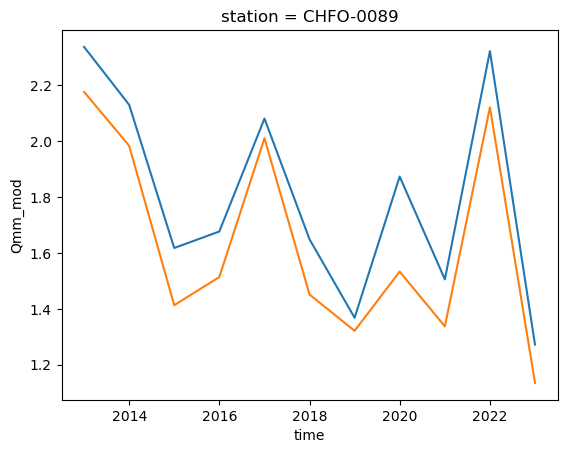

In [92]:
ds_yearly.Qmm.isel(station=0).plot()
ds_yearly.Qmm_mod.isel(station=0).plot()

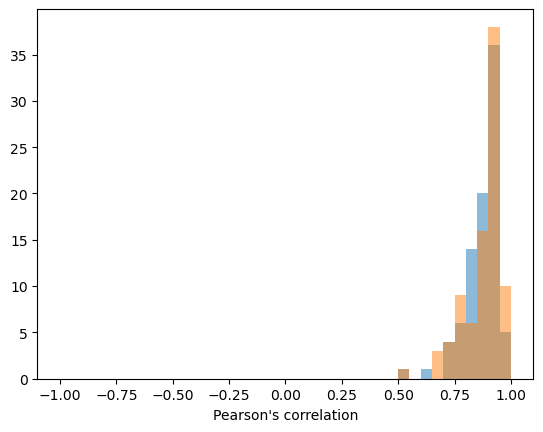

In [40]:
bins = np.linspace(-1, 1, 41)
x_mod.r.plot.hist(bins=bins, alpha=0.5);
x_prevah.r.plot.hist(bins=bins, alpha=0.5);

/mydata/machflow/basil/mach-flow/utils/analysis.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


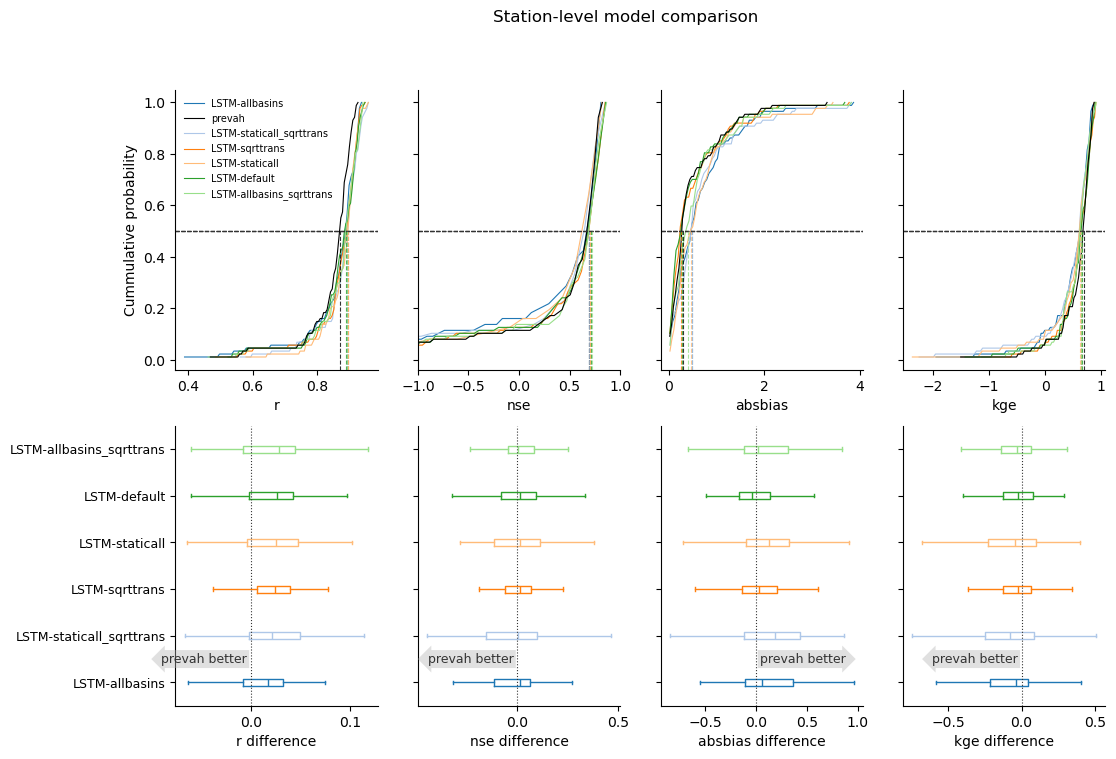

In [26]:
plot_model_comp('../../runs/basin_level/')

In [2]:
xval_ds = load_config_xval_test_set(
    path='/mydata/machflow/basil/runs/basin_level/', nonbool_kwords=['static']).drop_vars('tau')
met_ds = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_mod, metrics='all', dim='time')
met_ds_p = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_prevah, metrics='all', dim='time')
met_ds_glob = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_mod, metrics=['mse'], dim=None)
met_ds_glob_p = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_prevah, metrics=['mse'], dim=None)

In [19]:
best_ds = load_xval_test_set('../../runs/basin_level/default/LSTM/xval/')[runoff_vars].sel(tau=0.5).drop_vars('tau')
met_ds_best = compute_metrics(best_ds.Qmm, mod=best_ds.Qmm_mod, dim='time')
met_ds_best_p = compute_metrics(best_ds.Qmm, mod=best_ds.Qmm_prevah, dim='time')

In [23]:
all_metrics = list(met_ds_best.data_vars)
x_mod = met_ds_best.to_dataframe().reset_index()
x_mod['source'] = 'mod'
x_pre = met_ds_best_p.to_dataframe().reset_index()
x_pre['source'] = 'prevah'
x_both = pd.concat((x_mod, x_pre))

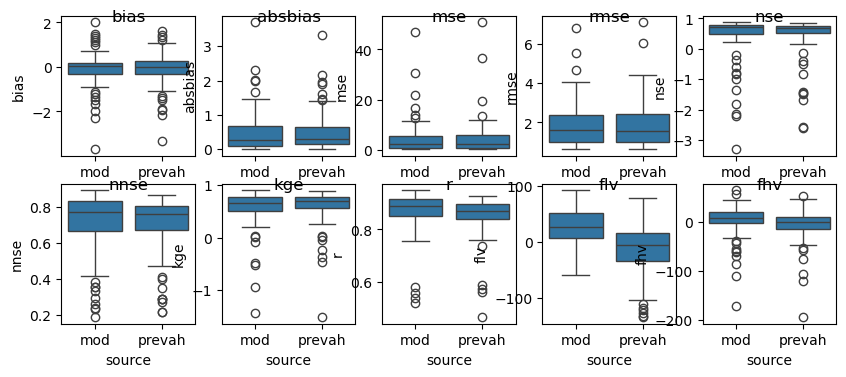

In [24]:
n = len(all_metrics)

n_cols = n // 2
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i, metric in enumerate(all_metrics):
    ax = axes.flatten()[i]
    sns.boxplot(x='source', y=metric, data=x_both, ax=ax)
    ax.set_title(metric, y=0.9)